# Classification with Inception-V3

In this example we'll classify an image with the [Inception-V3](https://www.tensorflow.org/versions/r0.9/tutorials/image_recognition/index.html).

We'll dig into the model to inspect features and the output.

### 1. Setup

* First, set up Python, `numpy`, and `matplotlib`.

In [1]:
# set up Python environment: numpy for numerical routines, and matplotlib for plotting
import numpy as np
import matplotlib.pyplot as plt
# display plots in this notebook
%matplotlib inline

# set display defaults
plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

* Load `caffe`.

In [2]:
# The caffe module needs to be on the Python path;
#  we'll add it here explicitly.
import sys
caffe_root = '../'  # this file should be run from {caffe_root}/examples (otherwise change this line)
sys.path.insert(0, caffe_root + 'python')

import caffe
# If you get "No module named _caffe", either you have not built pycaffe or you have the wrong path.

* If needed, download the reference model ("CaffeNet", a variant of AlexNet).

In [3]:
import os
if os.path.isfile(caffe_root + 'models/inception_v3/inception_v3.caffemodel'):
    print 'Inception v3 found.'
else:
    sys.exit()

Inception v3 found.


### 2. Load net and set up input preprocessing

* Set Caffe to CPU mode and load the net from disk.

In [4]:
caffe.set_device(0)  # if we have multiple GPUs, pick the first one
caffe.set_mode_gpu()

model_def = caffe_root + 'models/inception_v3/inception_v3_deploy.prototxt'
model_weights = caffe_root + 'models/inception_v3/inception_v3.caffemodel'

net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)

* Set up input preprocessing. (We'll use Caffe's `caffe.io.Transformer` to do this, but this step is independent of other parts of Caffe, so any custom preprocessing code may be used).

    Our default CaffeNet is configured to take images in BGR format. Values are expected to start in the range [0, 255] and then have the mean ImageNet pixel value subtracted from them. In addition, the channel dimension is expected as the first (_outermost_) dimension.
    
    As matplotlib will load images with values in the range [0, 1] in RGB format with the channel as the _innermost_ dimension, we are arranging for the needed transformations here.

In [5]:
import caffe

mu = np.array([128.0, 128.0, 128.0])

# create transformer for the input called 'data'
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})

transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension
transformer.set_mean('data', mu)            # subtract the dataset-mean value in each channel
transformer.set_raw_scale('data', 255)      # rescale from [0, 1] to [0, 255]
transformer.set_input_scale('data', 1/128.0)
transformer.set_channel_swap('data', (2,1,0))  # swap channels from RGB to BGR

### 3. CPU classification

* Now we're ready to perform classification. Even though we'll only classify one image, we'll set a batch size of 50 to demonstrate batching.

In [6]:
# set the size of the input (we can skip this if we're happy
#  with the default; we can also change it later, e.g., for different batch sizes)
net.blobs['data'].reshape(1,        # batch size
                          3,         # 3-channel (BGR) images
                          299, 299)  # image size is 227x227

* Load an image (that comes with Caffe) and perform the preprocessing we've set up.

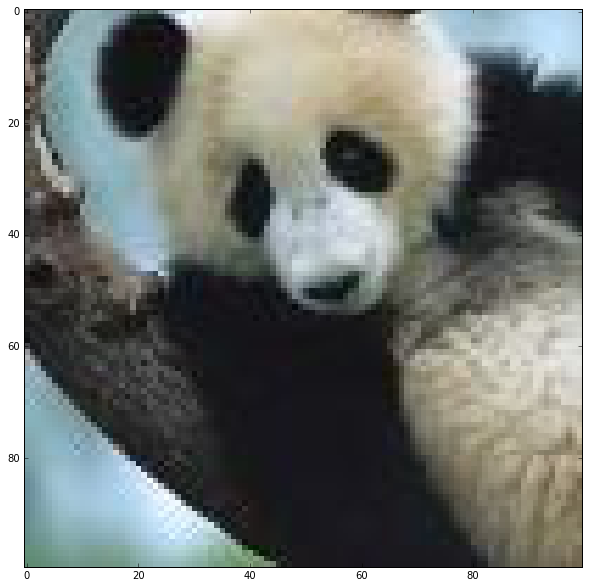

In [7]:
image = caffe.io.load_image(caffe_root + 'examples/images/cropped_panda.jpg')
transformed_image = transformer.preprocess('data', image)
plt.imshow(image)

#### * Adorable! Let's classify it!

In [8]:
# copy the image data into the memory allocated for the net
net.blobs['data'].data[...] = transformed_image

### perform classification
output = net.forward()

output_prob = output['softmax_prob'][0]  # the output probability vector for the first image in the batch

print output_prob.shape
print 'predicted class is:', output_prob.argmax()

(1008,)
predicted class is: 169


* The net gives us a vector of probabilities; the most probable class was the 169th one. But is that correct? Let's check the ImageNet labels...

In [9]:
from caffe.model_libs import *
from google.protobuf import text_format

# load ImageNet labels
labelmap_file = caffe_root + 'data/ILSVRC2016/labelmap_ilsvrc_clsloc.prototxt'
file = open(labelmap_file, 'r')
labelmap = caffe_pb2.LabelMap()
text_format.Merge(str(file.read()), labelmap)

def get_labelname(labels):
    num_labels = len(labelmap.item)
    labelnames = []
    if type(labels) is not list:
        labels = [labels]
    for label in labels:
        found = False
        for i in xrange(0, num_labels):
            if label == labelmap.item[i].label:
                found = True
                labelnames.append(labelmap.item[i].display_name)
                break
        assert found == True
    return labelnames

print 'output label:', get_labelname(output_prob.argmax())[0]

output label: giant_panda


* "Giant panda" is correct! But let's also look at other top (but less confident predictions).

In [10]:
# sort top five predictions from softmax output
top_inds = output_prob.argsort()[::-1][:5]  # reverse sort and take five largest items

print 'probabilities and labels:'
zip(output_prob[top_inds], get_labelname(top_inds.tolist()))

probabilities and labels:


[(0.94111753, u'giant_panda'),
 (0.0090998318, u'indri'),
 (0.0026912291, u'lesser_panda'),
 (0.00079203374, u'earthstar'),
 (0.00049125619, u'Madagascar_cat')]

* We see that less confident predictions are sensible.

### 5. Examining intermediate output

* A net is not just a black box; let's take a look at some of the parameters and intermediate activations.

First we'll see how to read out the structure of the net in terms of activation and parameter shapes.

* For each layer, let's look at the activation shapes, which typically have the form `(batch_size, channel_dim, height, width)`.

    The activations are exposed as an `OrderedDict`, `net.blobs`.

In [11]:
# for each layer, show the output shape
for layer_name, blob in net.blobs.iteritems():
    print layer_name + '\t' + str(blob.data.shape)

data	(1, 3, 299, 299)
conv	(1, 32, 149, 149)
conv_1	(1, 32, 147, 147)
conv_2	(1, 64, 147, 147)
pool	(1, 64, 73, 73)
conv_3	(1, 80, 73, 73)
conv_4	(1, 192, 71, 71)
pool_1	(1, 192, 35, 35)
pool_1_pool_1_0_split_0	(1, 192, 35, 35)
pool_1_pool_1_0_split_1	(1, 192, 35, 35)
pool_1_pool_1_0_split_2	(1, 192, 35, 35)
pool_1_pool_1_0_split_3	(1, 192, 35, 35)
mixed/conv	(1, 64, 35, 35)
mixed/tower/conv	(1, 48, 35, 35)
mixed/tower/conv_1	(1, 64, 35, 35)
mixed/tower_1/conv	(1, 64, 35, 35)
mixed/tower_1/conv_1	(1, 96, 35, 35)
mixed/tower_1/conv_2	(1, 96, 35, 35)
mixed/tower_2/pool	(1, 192, 35, 35)
mixed/tower_2/conv	(1, 32, 35, 35)
mixed/join	(1, 256, 35, 35)
mixed/join_mixed/join_0_split_0	(1, 256, 35, 35)
mixed/join_mixed/join_0_split_1	(1, 256, 35, 35)
mixed/join_mixed/join_0_split_2	(1, 256, 35, 35)
mixed/join_mixed/join_0_split_3	(1, 256, 35, 35)
mixed_1/conv	(1, 64, 35, 35)
mixed_1/tower/conv	(1, 48, 35, 35)
mixed_1/tower/conv_1	(1, 64, 35, 35)
mixed_1/tower_1/conv	(1, 64, 35, 35)
mixed_1/towe

* Now look at the parameter shapes. The parameters are exposed as another `OrderedDict`, `net.params`. We need to index the resulting values with either `[0]` for weights or `[1]` for biases.

    The param shapes typically have the form `(output_channels, input_channels, filter_height, filter_width)` (for the weights) and the 1-dimensional shape `(output_channels,)` (for the biases).

In [12]:
for layer_name, param in net.params.iteritems():
    if 'bn' in layer_name:
        print layer_name + '\t' + str(param[0].data.shape), str(param[1].data.shape), str(param[2].data.shape)
    elif 'scale' in layer_name or layer_name == 'softmax':
        print layer_name + '\t' + str(param[0].data.shape), str(param[1].data.shape)
    else:
        print layer_name + '\t' + str(param[0].data.shape)

conv	(32, 3, 3, 3)
conv_bn	(32,) (32,) (1,)
conv_bias	(32,)
conv_1	(32, 32, 3, 3)
conv_1_bn	(32,) (32,) (1,)
conv_1_bias	(32,)
conv_2	(64, 32, 3, 3)
conv_2_bn	(64,) (64,) (1,)
conv_2_bias	(64,)
conv_3	(80, 64, 1, 1)
conv_3_bn	(80,) (80,) (1,)
conv_3_bias	(80,)
conv_4	(192, 80, 3, 3)
conv_4_bn	(192,) (192,) (1,)
conv_4_bias	(192,)
mixed/conv	(64, 192, 1, 1)
mixed/conv_bn	(64,) (64,) (1,)
mixed/conv_bias	(64,)
mixed/tower/conv	(48, 192, 1, 1)
mixed/tower/conv_bn	(48,) (48,) (1,)
mixed/tower/conv_bias	(48,)
mixed/tower/conv_1	(64, 48, 5, 5)
mixed/tower/conv_1_bn	(64,) (64,) (1,)
mixed/tower/conv_1_bias	(64,)
mixed/tower_1/conv	(64, 192, 1, 1)
mixed/tower_1/conv_bn	(64,) (64,) (1,)
mixed/tower_1/conv_bias	(64,)
mixed/tower_1/conv_1	(96, 64, 3, 3)
mixed/tower_1/conv_1_bn	(96,) (96,) (1,)
mixed/tower_1/conv_1_bias	(96,)
mixed/tower_1/conv_2	(96, 96, 3, 3)
mixed/tower_1/conv_2_bn	(96,) (96,) (1,)
mixed/tower_1/conv_2_bias	(96,)
mixed/tower_2/conv	(32, 192, 1, 1)
mixed/tower_2/conv_bn	(32,) (3

* Since we're dealing with four-dimensional data here, we'll define a helper function for visualizing sets of rectangular heatmaps.

In [13]:
def vis_square(data):
    """Take an array of shape (n, height, width) or (n, height, width, 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""
    
    # normalize data for display
    data = (data - data.min()) / (data.max() - data.min())
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
               (0, 1), (0, 1))                 # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data); plt.axis('off')

* First we'll look at the first layer filters, `conv1`

[[ 0.01260555 -0.00162022  0.09091024]
 [-0.10557341 -0.15358226 -0.04656353]
 [-0.16552085 -0.17688492 -0.10908931]]


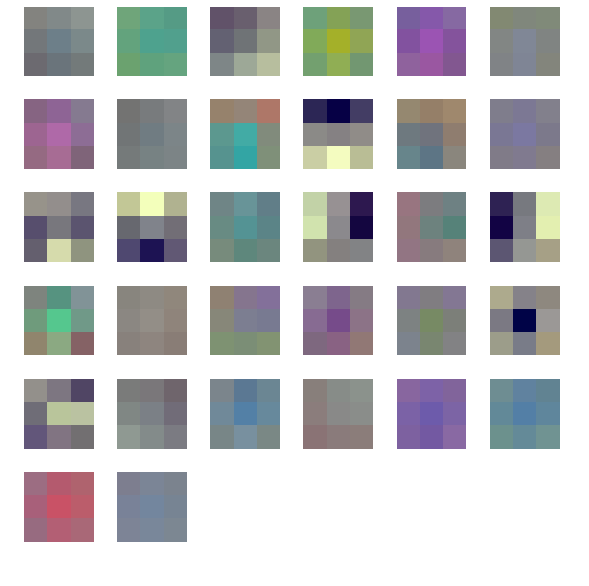

In [14]:
# the parameters are a list of [weights, biases]
filters = net.params['conv'][0].data
print filters[(0),(0)]
vis_square(filters.transpose(0, 2, 3, 1))

* The first layer output, `conv1` (rectified responses of the filters above, first 36 only)

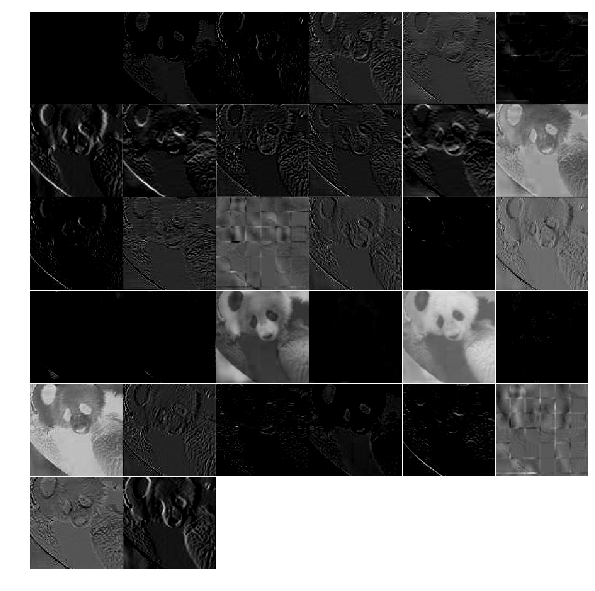

In [15]:
feat = net.blobs['conv_1'].data[0, :32]
vis_square(feat)

* The fifth layer after pooling, `pool5`

[[ 3.12518811  2.62453365  2.53943014 ...,  0.1014272   0.50773937
   1.65399456]
 [ 2.73962688  1.33985364  1.53790259 ...,  0.          0.          0.45574632]
 [ 2.58312726  1.61969352  1.50551486 ...,  0.          0.          0.3848139 ]
 ..., 
 [ 1.71675909  0.56276274  0.42395294 ...,  1.63560033  1.67548656
   2.42273569]
 [ 2.31146455  1.39116156  1.19222748 ...,  1.15682399  1.19950581
   2.40271688]
 [ 3.24485111  2.26807785  2.22769785 ...,  2.71704149  2.6820693
   3.31729937]]


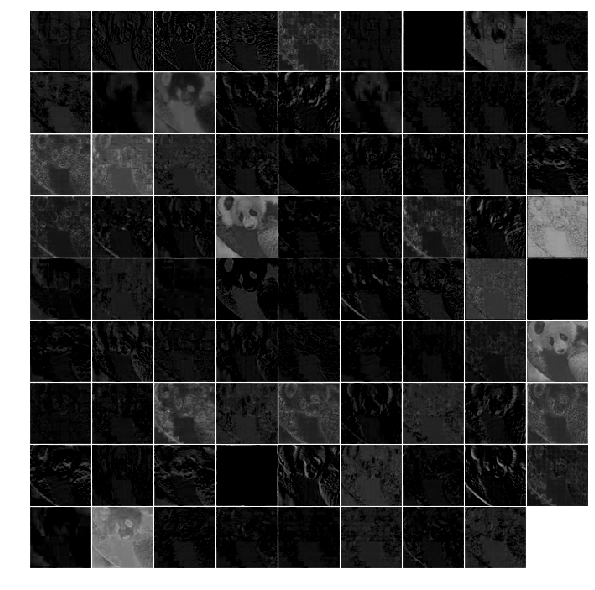

In [16]:
feat = net.blobs['conv_3'].data[0]
print feat[7,]
vis_square(feat)

* The first fully connected layer, `fc6` (rectified)

    We show the output values and the histogram of the positive values

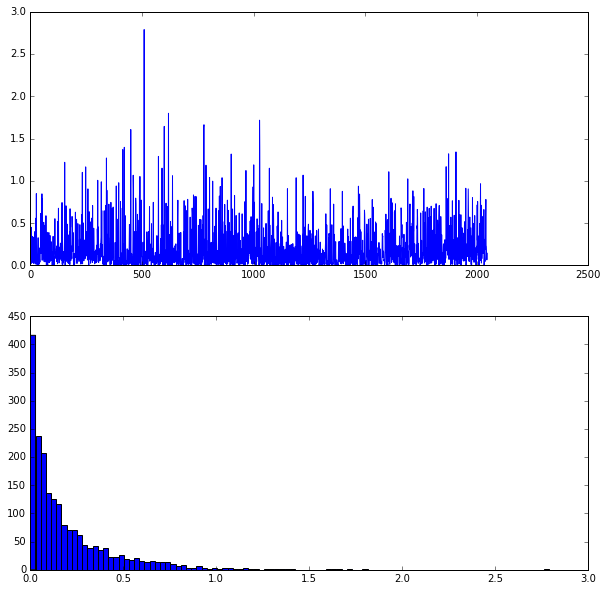

In [17]:
feat = net.blobs['pool_3'].data[0]
plt.subplot(2, 1, 1)
plt.plot(feat.flat)
plt.subplot(2, 1, 2)
_ = plt.hist(feat.flat[feat.flat > 0], bins=100)

* The final probability output, `prob`

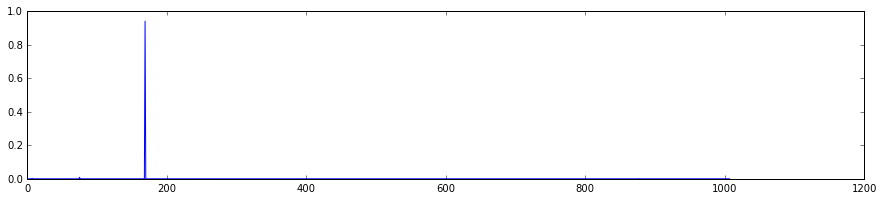

In [18]:
feat = net.blobs['softmax_prob'].data[0]
plt.figure(figsize=(15, 3))
plt.plot(feat.flat)

Note the cluster of strong predictions; the labels are sorted semantically. The top peaks correspond to the top predicted labels, as shown above.